In [1]:
#%env CUDA_VISIBLE_DEVICES=1

In [1]:
from collections import Counter
from glob import glob
from itertools import islice

import matplotlib.pyplot as plt  
import numpy as np
import pandas as pd
import scipy
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn.manifold import TSNE, Isomap
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from era_data import TabletPeriodDataset
from era_model import EraClassifier

# from lime import lime_image
# from skimage.segmentation import mark_boundaries

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Load data and model

In [3]:
IMG_DIR = 'output/images_preprocessed'

VERSION_NAME =  'period_clf_bs16_lr1e-05_20epochs-resnet50-94936_samples_preprocessed-masked_April16-80-10-10_train_test_val-2'

#'period_clf_bs16_lr1e-05_20epochs-resnet50-94936_samples_preprocessed-masked_April09-70-10-20_train_test_val'

#'period_clf_bs16_lr1e-05_20epochs-resnet50-94936_samples_preprocessed-masked_April08-70-10-20_train_test_val'

#'period_clf_bs16_lr5e-05_15epochs-resnet50-94936_samples_preprocessed-masked_March29-1000_test_val'

CKPT_FN = glob(f'lightning_logs/{VERSION_NAME}/checkpoints/*')[0]
CKPT_FN

'lightning_logs/period_clf_bs16_lr1e-05_20epochs-resnet50-94936_samples_preprocessed-masked_April16-80-10-10_train_test_val-2/checkpoints/epoch=3-step=18513.ckpt'

In [4]:
num_classes = len(TabletPeriodDataset.PERIOD_INDICES) + 2
num_classes

24

In [5]:
%time model = EraClassifier.load_from_checkpoint(CKPT_FN, num_classes=num_classes)

/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CPU times: user 3 s, sys: 234 ms, total: 3.24 s
Wall time: 2.23 s


In [6]:
model.to(device);

In [7]:
model.eval();

In [8]:
test_ids = pd.read_csv(f'output/clf_ids/period-test-{VERSION_NAME}.csv', header=None)[0].astype(str)

In [9]:
len(test_ids)

9494

In [10]:
ds_test = TabletPeriodDataset(IDS=test_ids, mask=True, IMG_DIR=IMG_DIR)

Filtering 94936 IDS down to provided 9494...


In [11]:
def collate_fn(batch):
    
    data = torch.stack([torch.from_numpy(sample[1]) for sample in batch])
    labels = torch.tensor([sample[2] for sample in batch])

    return data, labels

In [12]:
dl_test = DataLoader(ds_test, batch_size=16, collate_fn = collate_fn, shuffle=False, num_workers=1)

# Calculate predictions

In [13]:
def dl2data(dl, MAX_N=None):
    logits = []
    y_true = []
    with torch.no_grad():
        gen = tqdm(dl) if MAX_N is None else tqdm(islice(dl, MAX_N), total=MAX_N)
        for X, y in gen:
            y_true.append(y.numpy())
            logits.append(model(X.to(device)).cpu().numpy())
    y_true = np.hstack(y_true)
    logits = np.vstack(logits)
    return logits, y_true

In [14]:
logits, y_true = dl2data(dl_test)

  0%|          | 0/582 [00:00<?, ?it/s]

In [15]:
y_true.shape, logits.shape

((9297,), (9297, 24))

In [16]:
y_pred = logits.argmax(axis=-1)
y_prob = scipy.special.softmax(logits, axis=-1)

In [17]:
y_pred.shape, y_prob.shape

((9297,), (9297, 24))

In [18]:
(y_pred == y_true).mean()

0.7677745509304077

# Check metrics

In [19]:
EARLY_BRONZE = {
    'Old Akkadian', 'Ur III',
    'ED IIIb', 'Uruk III',
    'Proto-Elamite', 'Lagash II',
    'Ebla', 'ED IIIa', 'ED I-II',
    'Uruk IV', 'Linear Elamite',
    'Harappan'
    
}
MID_LATE_BRONZE = {
    'Early Old Babylonian',
    'Old Babylonian', 'Old Assyrian',
    'Middle Babylonian', 'Middle Assyrian',
    'Middle Elamite', 'Middle Hittite'
}
IRON = {
    'Neo-Babylonian', 'Neo-Assyrian',
    'Achaemenid', 'Hellenistic',
    'Neo-Elamite'
}
ERA_MAP = {
    **{K: 'EB' for K in EARLY_BRONZE},
    **{K: 'MLB' for K in MID_LATE_BRONZE},
    **{K: 'I' for K in IRON},
}

In [20]:
def explain(period):
    return f'{period} ({ERA_MAP.get(period, "?")})'
explain('Neo-Babylonian')

'Neo-Babylonian (I)'

In [21]:
idx2period = {v: k for k, v in TabletPeriodDataset.PERIOD_INDICES.items()}
idx2period[0] = 'other'

In [22]:
idx2period[0], idx2period[5]

('other', 'Neo-Babylonian')

In [23]:
list(set(y_true) | set(y_pred))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [24]:
indices = list(set(y_true) | set(y_pred))
print(len(indices))
print(indices)
PERIOD_LABELS = [explain(idx2period[i]) for i in indices]
print(PERIOD_LABELS)

22
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
['other (?)', 'Ur III (EB)', 'Neo-Assyrian (I)', 'Old Babylonian (MLB)', 'Middle Babylonian (MLB)', 'Neo-Babylonian (I)', 'Old Akkadian (EB)', 'Achaemenid (I)', 'Early Old Babylonian (MLB)', 'ED IIIb (EB)', 'Middle Assyrian (MLB)', 'Old Assyrian (MLB)', 'Uruk III (EB)', 'Proto-Elamite (EB)', 'Lagash II (EB)', 'Ebla (EB)', 'ED IIIa (EB)', 'Hellenistic (I)', 'ED I-II (EB)', 'Middle Elamite (MLB)', 'Middle Hittite (MLB)', 'Uruk IV (EB)']


In [25]:
print(classification_report(y_true, y_pred, target_names=PERIOD_LABELS))

                            precision    recall  f1-score   support

                 other (?)       0.00      0.00      0.00        49
               Ur III (EB)       0.87      0.88      0.87      2799
          Neo-Assyrian (I)       0.93      0.96      0.95      2304
      Old Babylonian (MLB)       0.57      0.78      0.66      1671
   Middle Babylonian (MLB)       0.50      0.44      0.47       602
        Neo-Babylonian (I)       0.69      0.48      0.57       502
         Old Akkadian (EB)       0.72      0.60      0.65       304
            Achaemenid (I)       0.74      0.43      0.55       200
Early Old Babylonian (MLB)       0.79      0.33      0.46       205
              ED IIIb (EB)       0.68      0.68      0.68       154
     Middle Assyrian (MLB)       0.69      0.22      0.34       149
        Old Assyrian (MLB)       0.89      0.67      0.77       147
             Uruk III (EB)       0.50      0.26      0.34        23
        Proto-Elamite (EB)       0.00      0.00

/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [26]:
# let's just use classes with support >=10, everything else goes to 0: other
COMMON_LABELS = list({k for k, v in Counter(y_true).items() if v >= 40})
print(f'Common labels: ({len(COMMON_LABELS)})')
[(i, explain(idx2period[i])) for i in COMMON_LABELS]

Common labels: (14)


[(0, 'other (?)'),
 (1, 'Ur III (EB)'),
 (2, 'Neo-Assyrian (I)'),
 (3, 'Old Babylonian (MLB)'),
 (4, 'Middle Babylonian (MLB)'),
 (5, 'Neo-Babylonian (I)'),
 (6, 'Old Akkadian (EB)'),
 (7, 'Achaemenid (I)'),
 (8, 'Early Old Babylonian (MLB)'),
 (9, 'ED IIIb (EB)'),
 (10, 'Middle Assyrian (MLB)'),
 (11, 'Old Assyrian (MLB)'),
 (14, 'Lagash II (EB)'),
 (15, 'Ebla (EB)')]

In [27]:
y_true_c = y_true.copy()
y_true_c[~np.isin(y_true, COMMON_LABELS)] = 0
print((~np.isin(y_true, COMMON_LABELS)).mean(), 'changed to "other"')

0.010648596321393998 changed to "other"


In [28]:
y_pred_c = y_pred.copy()
y_pred_c[~np.isin(y_pred, COMMON_LABELS)] = 0
print((~np.isin(y_pred, COMMON_LABELS)).mean(), 'changed to "other"')

0.0065612563192427665 changed to "other"


In [29]:
indices_c = list(set(y_pred_c))
print(len(indices_c))
print(indices_c)
PERIOD_LABELS_C = [explain(idx2period[i]) for i in indices_c]
print(PERIOD_LABELS_C)

14
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15]
['other (?)', 'Ur III (EB)', 'Neo-Assyrian (I)', 'Old Babylonian (MLB)', 'Middle Babylonian (MLB)', 'Neo-Babylonian (I)', 'Old Akkadian (EB)', 'Achaemenid (I)', 'Early Old Babylonian (MLB)', 'ED IIIb (EB)', 'Middle Assyrian (MLB)', 'Old Assyrian (MLB)', 'Lagash II (EB)', 'Ebla (EB)']


In [30]:
print(classification_report(y_true_c, y_pred_c, target_names=PERIOD_LABELS_C))

                            precision    recall  f1-score   support

                 other (?)       0.36      0.15      0.21       148
               Ur III (EB)       0.87      0.88      0.87      2799
          Neo-Assyrian (I)       0.93      0.96      0.95      2304
      Old Babylonian (MLB)       0.57      0.78      0.66      1671
   Middle Babylonian (MLB)       0.50      0.44      0.47       602
        Neo-Babylonian (I)       0.69      0.48      0.57       502
         Old Akkadian (EB)       0.72      0.60      0.65       304
            Achaemenid (I)       0.74      0.43      0.55       200
Early Old Babylonian (MLB)       0.79      0.33      0.46       205
              ED IIIb (EB)       0.68      0.68      0.68       154
     Middle Assyrian (MLB)       0.69      0.22      0.34       149
        Old Assyrian (MLB)       0.89      0.67      0.77       147
            Lagash II (EB)       0.73      0.72      0.72        64
                 Ebla (EB)       0.63      0.56

In [31]:
Y = label_binarize(y_true, classes=np.unique(y_true))
n_classes = Y.shape[1]

auc_scores = []
for i in range(n_classes):
    auc = roc_auc_score(Y[:, i], y_prob[:, i])
    auc_scores.append(auc)

macro_ovr_auc = np.mean(auc_scores)
print(f"Macro-OvR-AUC: {macro_ovr_auc}")

Macro-OvR-AUC: 0.9286918558618358


In [32]:
cm = confusion_matrix(y_true_c, y_pred_c)
cm # rows: ground truth; cols: prediction

array([[  22,   23,   14,   62,    4,    3,    8,    0,    0,    7,    2,
           3,    0,    0],
       [   7, 2454,   19,  212,   47,    9,   23,    2,    5,    4,    4,
           6,    5,    2],
       [   8,    6, 2213,   51,    8,   14,    0,    0,    0,    0,    0,
           0,    1,    3],
       [   6,  146,   46, 1303,  104,   23,   12,    5,    7,   10,    2,
           0,    0,    7],
       [   3,   50,   13,  250,  263,   10,    5,    3,    0,    3,    0,
           2,    0,    0],
       [   4,   28,   23,  143,   36,  241,    5,   17,    2,    0,    3,
           0,    0,    0],
       [   3,   30,    7,   47,   13,    2,  181,    0,    0,   14,    0,
           0,    7,    0],
       [   2,   13,    4,   37,   18,   37,    0,   87,    1,    0,    1,
           0,    0,    0],
       [   0,   26,    6,   77,   15,    6,    2,    1,   67,    0,    2,
           0,    2,    1],
       [   1,    6,    4,   24,    1,    0,   10,    0,    0,  104,    1,
           0,    

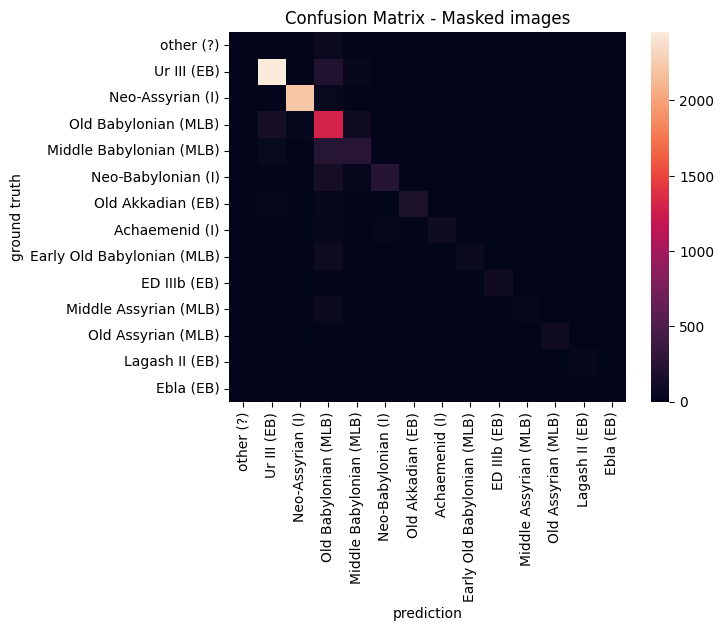

In [33]:
sns.heatmap(cm, xticklabels=PERIOD_LABELS_C, yticklabels=PERIOD_LABELS_C);
plt.xlabel('prediction');
plt.ylabel('ground truth')
plt.title("Confusion Matrix - Masked images");

In [34]:
cm_rownorm = (cm / cm.sum(axis=1)[:, None])

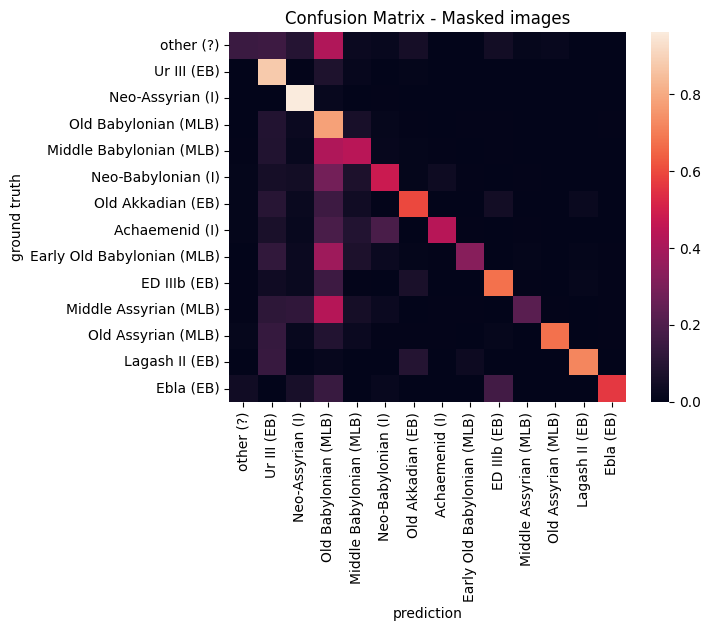

In [35]:
sns.heatmap(cm_rownorm, xticklabels=PERIOD_LABELS_C, yticklabels=PERIOD_LABELS_C);
plt.xlabel('prediction');
plt.ylabel('ground truth')
plt.title("Confusion Matrix - Masked images");

In [36]:
cm_df = pd.DataFrame(cm, columns=PERIOD_LABELS_C, index=PERIOD_LABELS_C)
cm_df

,other (?),Ur III (EB),Neo-Assyrian (I),Old Babylonian (MLB),Middle Babylonian (MLB),Neo-Babylonian (I),Old Akkadian (EB),Achaemenid (I),Early Old Babylonian (MLB),ED IIIb (EB),Middle Assyrian (MLB),Old Assyrian (MLB),Lagash II (EB),Ebla (EB)
other (?),22,23,14,62,4,3,8,0,0,7,2,3,0,0
Ur III (EB),7,2454,19,212,47,9,23,2,5,4,4,6,5,2
Neo-Assyrian (I),8,6,2213,51,8,14,0,0,0,0,0,0,1,3
Old Babylonian (MLB),6,146,46,1303,104,23,12,5,7,10,2,0,0,7
Middle Babylonian (MLB),3,50,13,250,263,10,5,3,0,3,0,2,0,0
Neo-Babylonian (I),4,28,23,143,36,241,5,17,2,0,3,0,0,0
Old Akkadian (EB),3,30,7,47,13,2,181,0,0,14,0,0,7,0
Achaemenid (I),2,13,4,37,18,37,0,87,1,0,1,0,0,0
Early Old Babylonian (MLB),0,26,6,77,15,6,2,1,67,0,2,0,2,1
ED IIIb (EB),1,6,4,24,1,0,10,0,0,104,1,0,2,1


In [37]:
cm_rn_df = pd.DataFrame(cm_rownorm, columns=PERIOD_LABELS_C, index=PERIOD_LABELS_C)
cm_rn_df

,other (?),Ur III (EB),Neo-Assyrian (I),Old Babylonian (MLB),Middle Babylonian (MLB),Neo-Babylonian (I),Old Akkadian (EB),Achaemenid (I),Early Old Babylonian (MLB),ED IIIb (EB),Middle Assyrian (MLB),Old Assyrian (MLB),Lagash II (EB),Ebla (EB)
other (?),0.148649,0.155405,0.094595,0.418919,0.027027,0.020270,0.054054,0.000000,0.000000,0.047297,0.013514,0.020270,0.000000,0.000000
Ur III (EB),0.002501,0.876742,0.006788,0.075741,0.016792,0.003215,0.008217,0.000715,0.001786,0.001429,0.001429,0.002144,0.001786,0.000715
Neo-Assyrian (I),0.003472,0.002604,0.960503,0.022135,0.003472,0.006076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000434,0.001302
Old Babylonian (MLB),0.003591,0.087373,0.027528,0.779773,0.062238,0.013764,0.007181,0.002992,0.004189,0.005984,0.001197,0.000000,0.000000,0.004189
Middle Babylonian (MLB),0.004983,0.083056,0.021595,0.415282,0.436877,0.016611,0.008306,0.004983,0.000000,0.004983,0.000000,0.003322,0.000000,0.000000
Neo-Babylonian (I),0.007968,0.055777,0.045817,0.284861,0.071713,0.480080,0.009960,0.033865,0.003984,0.000000,0.005976,0.000000,0.000000,0.000000
Old Akkadian (EB),0.009868,0.098684,0.023026,0.154605,0.042763,0.006579,0.595395,0.000000,0.000000,0.046053,0.000000,0.000000,0.023026,0.000000
Achaemenid (I),0.010000,0.065000,0.020000,0.185000,0.090000,0.185000,0.000000,0.435000,0.005000,0.000000,0.005000,0.000000,0.000000,0.000000
Early Old Babylonian (MLB),0.000000,0.126829,0.029268,0.375610,0.073171,0.029268,0.009756,0.004878,0.326829,0.000000,0.009756,0.000000,0.009756,0.004878
ED IIIb (EB),0.006494,0.038961,0.025974,0.155844,0.006494,0.000000,0.064935,0.000000,0.000000,0.675325,0.006494,0.000000,0.012987,0.006494


In [38]:
cm_df.loc['Early Old Babylonian (MLB)']

other (?)                      0
Ur III (EB)                   26
Neo-Assyrian (I)               6
Old Babylonian (MLB)          77
Middle Babylonian (MLB)       15
Neo-Babylonian (I)             6
Old Akkadian (EB)              2
Achaemenid (I)                 1
Early Old Babylonian (MLB)    67
ED IIIb (EB)                   0
Middle Assyrian (MLB)          2
Old Assyrian (MLB)             0
Lagash II (EB)                 2
Ebla (EB)                      1
Name: Early Old Babylonian (MLB), dtype: int64

In [39]:
cm_rn_df.loc['Early Old Babylonian (MLB)']

other (?)                     0.000000
Ur III (EB)                   0.126829
Neo-Assyrian (I)              0.029268
Old Babylonian (MLB)          0.375610
Middle Babylonian (MLB)       0.073171
Neo-Babylonian (I)            0.029268
Old Akkadian (EB)             0.009756
Achaemenid (I)                0.004878
Early Old Babylonian (MLB)    0.326829
ED IIIb (EB)                  0.000000
Middle Assyrian (MLB)         0.009756
Old Assyrian (MLB)            0.000000
Lagash II (EB)                0.009756
Ebla (EB)                     0.004878
Name: Early Old Babylonian (MLB), dtype: float64

# Hierarchical clustering on confusion matrix

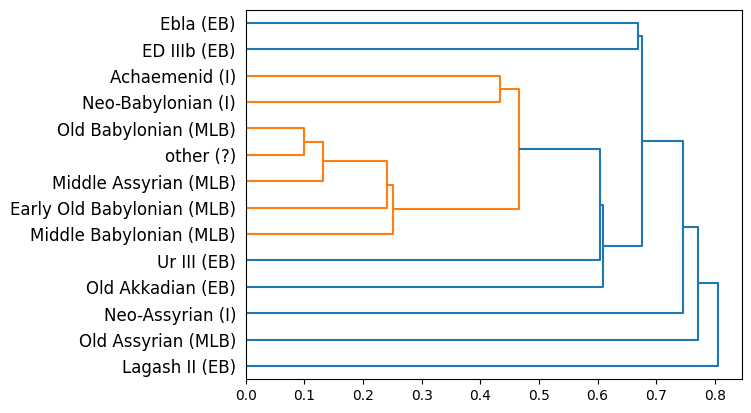

In [47]:
Y = hierarchy.distance.pdist(cm_rownorm, metric='cosine')

Z = hierarchy.linkage(Y, method='single')

ax = hierarchy.dendrogram(Z, show_contracted=True, labels=PERIOD_LABELS_C, orientation='right')

# Clustering feature vectors using model as feature extractor

In [41]:
activation = {}
def get_activation(name):
    def hook(model, inp, output):
        activation[name] = output.detach()
    return hook

In [42]:
model.core.avgpool.register_forward_hook(get_activation('ap'))
# model.core.fc.register_forward_hook(get_activation('fc'))

In [43]:
dl_test = DataLoader(ds_test, batch_size=16, shuffle=False, num_workers=1)

In [44]:
def extract_features(dl, MAX_N=None):
    outs = []
    with torch.no_grad():
        gen = tqdm(dl) if MAX_N is None else tqdm(islice(dl, MAX_N), total=MAX_N)
        for _, X, y, _, _ in gen:
            model(X.to(device))
            outs.append(activation['ap'].cpu().numpy()[..., 0, 0])
    return np.vstack(outs)

In [45]:
feats = extract_features(dl_test)

  0%|          | 0/582 [00:00<?, ?it/s]

In [46]:
feats

array([[0.55308694, 0.12234265, 0.23745522, ..., 0.2983529 , 0.6579284 ,
        0.45280874],
       [0.40125853, 0.4990046 , 0.5618205 , ..., 0.23884645, 0.20359863,
        0.43745738],
       [0.5761424 , 0.40667367, 0.5873353 , ..., 0.25542536, 0.534234  ,
        0.34549454],
       ...,
       [0.17359248, 0.27915442, 0.69933295, ..., 0.1703944 , 0.58671373,
        0.09011514],
       [0.24985024, 0.32667175, 0.30659777, ..., 0.5434741 , 0.65835583,
        0.20670988],
       [0.16775942, 0.21582443, 0.48213655, ..., 0.56143045, 0.7951739 ,
        0.14112777]], dtype=float32)

In [47]:
feats.shape

(17599, 2048)

In [48]:
%time F = TSNE(n_components=2, init='pca').fit_transform(feats)
# learning_rate='auto' -- https://www.pythonfixing.com/2021/11/fixed-sklearnmanifoldtsne-typeerror.html

CPU times: user 13min 17s, sys: 2.21 s, total: 13min 19s
Wall time: 2min 50s


In [49]:
%time F2 = Isomap(n_components=10).fit_transform(feats)

CPU times: user 17min 49s, sys: 22 s, total: 18min 11s
Wall time: 5min 2s


Text(0.5, 1.0, 'ISOMAP')

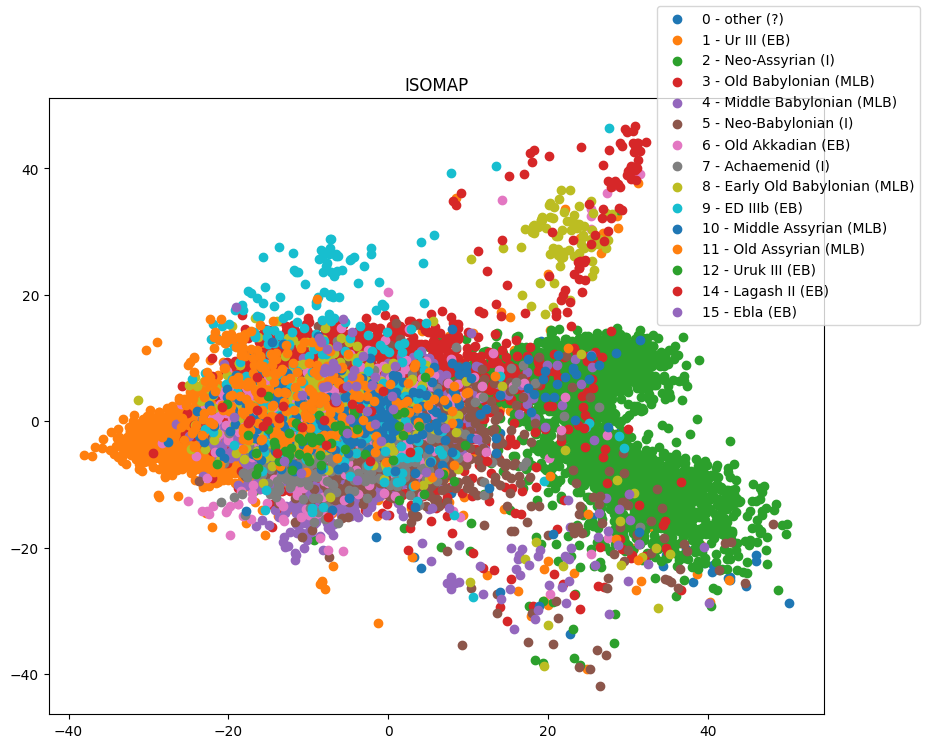

In [50]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)
for period in set(y_true_c):
    ax.scatter(F2[y_true_c == period, 0], F2[y_true_c == period, 4], label=f'{period} - {explain(idx2period[period])}')
fig.legend();
plt.title('ISOMAP')

In [51]:
idx2period[period]

'Ebla'

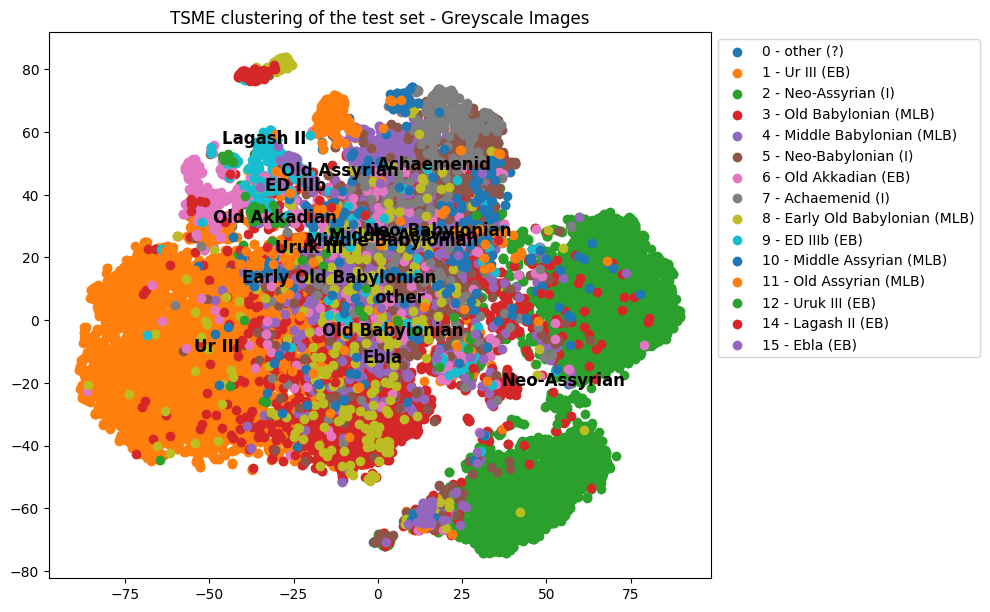

In [52]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

for period in set(y_true_c):
    period_data = F[y_true_c == period]
    
    # Scatter plot for the period.
    ax.scatter(period_data[:, 0], period_data[:, 1], label=f'{period} - {explain(idx2period[period])}')
    
    centroid = np.mean(period_data, axis=0)
    
    ax.text(centroid[0], centroid[1], f'{idx2period[period]}', horizontalalignment='center', verticalalignment='center', fontsize=12, weight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.title('TSME clustering of the test set - Greyscale Images')
scatter_pdf_path = 'output/plots/TSNEclusteringGreyscale.pdf'
plt.savefig(scatter_pdf_path, format='pdf')

#plt.show()

# Sample Masked Images

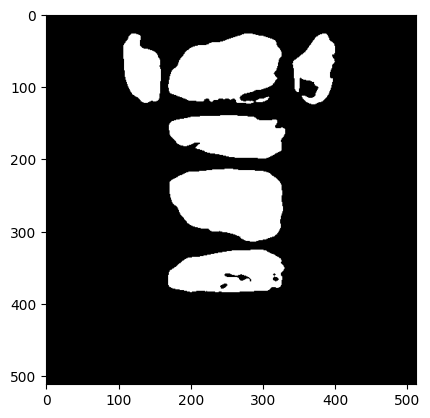

In [52]:
ID = np.random.choice(np.where(y_true == 2)[0])
plt.imshow(ds_test[ID][1], cmap='gray');

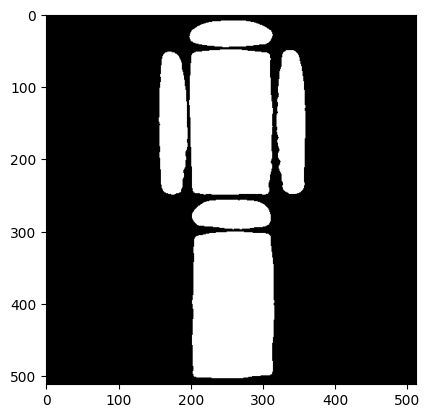

In [53]:
ID = np.random.choice(np.where(y_true == 5)[0])
plt.imshow(ds_test[ID][1], cmap='gray');

# Visualize mistakes

In [54]:
mistake_indices = np.where(y_true != y_pred)[0]
mistake_indices

array([ 72,  85,  88,  93,  96, 182, 189, 204, 219, 220, 225, 227, 228,
       232, 233, 239, 240, 241, 242, 245, 247, 249, 251, 254, 274, 275,
       278, 281, 323, 338, 340, 347, 348, 351, 354, 355, 356, 359, 362,
       363, 364, 365, 366, 369, 372, 373, 374, 377, 379, 382, 398, 399,
       400, 401, 402, 403, 407, 411, 412, 416, 417, 418, 419, 420, 424,
       425, 426, 427, 431, 432, 433, 435, 438, 439, 442, 443, 445, 446,
       447, 449, 450, 454, 456, 457, 459, 461, 465, 466, 467, 468, 469,
       470, 471, 472, 473, 474, 475, 477, 479, 482, 483, 487, 490, 491,
       492, 496, 499, 500, 501, 502, 505, 517, 520, 527, 528, 531, 562,
       574, 575, 576, 581, 582, 591, 592, 600, 603, 606, 607, 613, 614,
       615, 618, 619, 620, 621, 626, 629, 631, 634, 636, 637, 641, 643,
       646, 648, 649, 655, 661, 662, 663, 664, 665, 666, 669, 670, 674,
       706, 788, 789, 790, 792, 795, 810, 813, 814, 816, 817, 818, 820,
       826, 827, 831, 842, 843, 869, 870, 873, 878, 880, 881, 88

In [55]:
mistake_indices.shape

(207,)

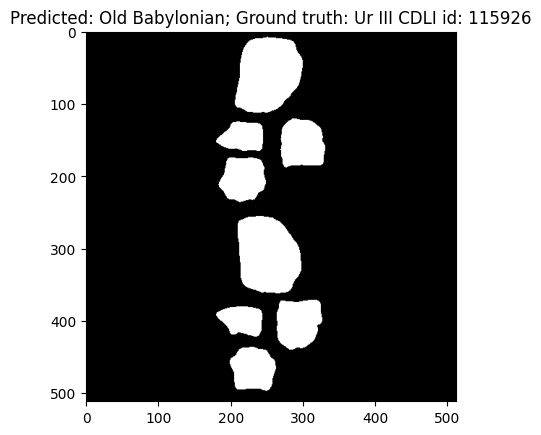

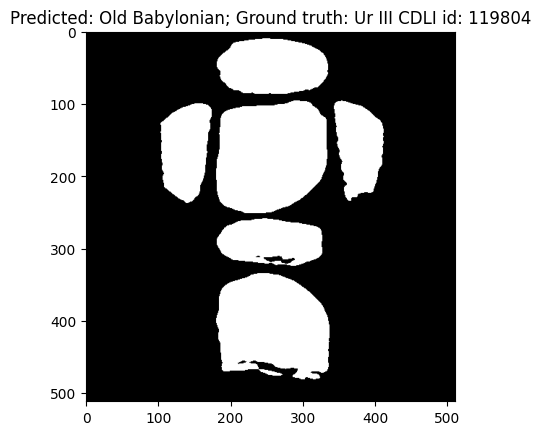

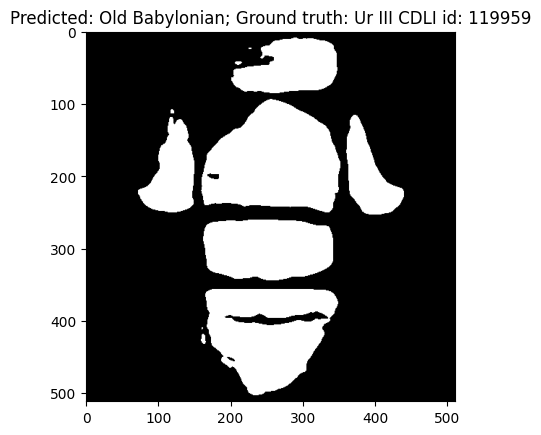

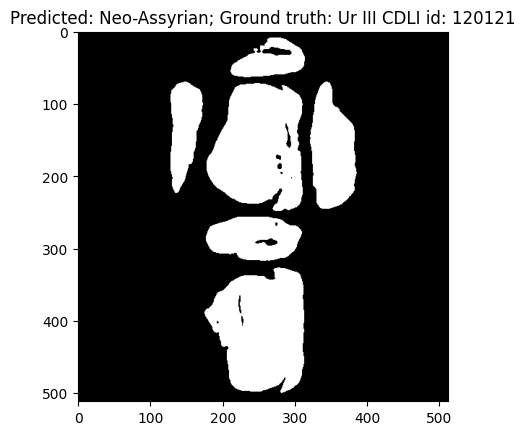

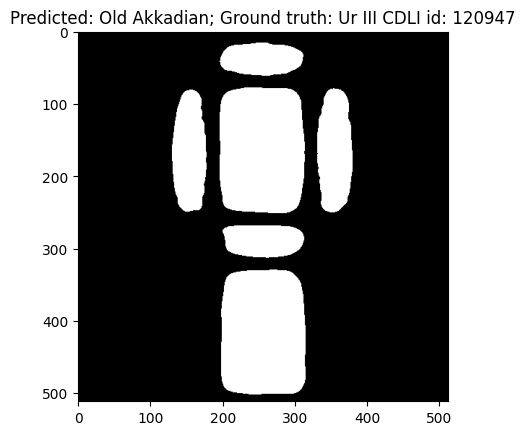

In [56]:
for idx in mistake_indices[:5]:
    
    cdli_id, X, y, _, _ = ds_test[idx]
    pred = y_pred[idx]
    
    plt.imshow(X, cmap='gray')
    plt.title(f'Predicted: {idx2period[pred]}; Ground truth: {idx2period[y]} CDLI id: {cdli_id}')
    plt.show()

# Explain predictions with Lime

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

In [72]:
# def preprocess_transform(img):
#     return img

In [73]:
# def batch_predict(X):
#     assert len(X.shape) == 4
#     # Lime adds channel dimension (gray2rgb); we remove it
#     # it also requires float64 (double) but our model needs float32
#     X_gray = X[..., 0].astype(np.float32) / 255
#     logits = model(torch.tensor(X_gray).to(device)).detach().cpu().numpy()
# #     probs = clf.predict_proba(logits)
#     probs = scipy.special.softmax(logits, axis=-1)
#     return probs

In [74]:
# explainer = lime_image.LimeImageExplainer()

In [75]:
# def explain_idx(idx):
#     X, y = ds_test[idx]
    
#     explanation = explainer.explain_instance(
#         X.astype(np.float64) * 255,
#         batch_predict,
#     #     top_labels=3,
#     #     hide_color=0,
#         batch_size=16,
#         num_samples=1000
#     )
    
#     top_label = explanation.top_labels[0]
    
#     temp, mask = explanation.get_image_and_mask(
#         top_label,
#         positive_only=False,
#         num_features=20,
#         hide_rest=False
#     )
    
#     img_boundary = mark_boundaries(temp/255.0, mask)
    
#     print(f'Item {idx}:')
#     print(f'Ground truth:\t{ERAS_SHORT[y]} ({y})')
#     print(f'Prediction:\t{ERAS_SHORT[top_label]} ({top_label})')

#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#     axs[0].imshow(X, cmap='gray');
#     axs[1].imshow(img_boundary);
#     plt.show()

In [76]:
# for i in range(10):
#     explain_idx(i)